In [2]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.cm as cm
import scipy.misc
import scipy.stats as sta
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')
import plotly.graph_objects as go
import plotly

In [3]:
def gauss(x_i,y_i,x_j,y_j,sigma):
    distance=(x_i-x_j)**2+(y_i-y_j)**2
    k=math.exp(-(distance/(2*(sigma**2))))
    return k

In [4]:
x=[10.4513669, 10.774399800000001, 10.296455400000001, 10.5491055, 10.586102499999999, 10.4864769, 10.786943699999998, 10.372424800000001, 10.7526273, 10.3372061, 10.2910757, 10.494461900000001, 10.3956903, 10.7937257, 10.414995900000001, 10.290274499999999, 10.4657499, 10.552505, 10.533116999999999, 10.5414212, 10.5508536, 10.456043600000001, 10.437694699999998, 10.458011500000001, 10.3144651, 10.673781, 10.5637337, 10.5496392, 10.577394, 10.5728433]

In [5]:
y=[11.6712715, 11.701397199999999, 11.728282400000001, 11.8064181, 11.8138058, 11.829955400000001, 11.843031, 11.8480226, 11.859788499999999, 11.8609146, 11.8715452, 11.8898059, 11.9276877, 11.9671872, 11.9879169, 12.0056867, 12.0126071, 12.018958099999999, 12.035048300000001, 12.040563699999998, 12.043571400000001, 12.0476369, 12.0502925, 12.0531618, 12.071192, 12.108383199999999, 12.155285699999999, 12.159091199999999, 12.1706769, 12.1919021]

In [6]:
ra_final=[10.414995900000001, 10.5414212]
dec_final=[11.9879169, 12.040563699999998]

In [7]:
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

In [8]:
coeff=((xmax-xmin)*(ymax-ymin)*36)

In [9]:
xx, yy = np.mgrid[xmin:xmax:10j, ymin:ymax:10j]

In [10]:
deltax=(xmax-xmin)/10
deltay=(ymax-ymin)/10

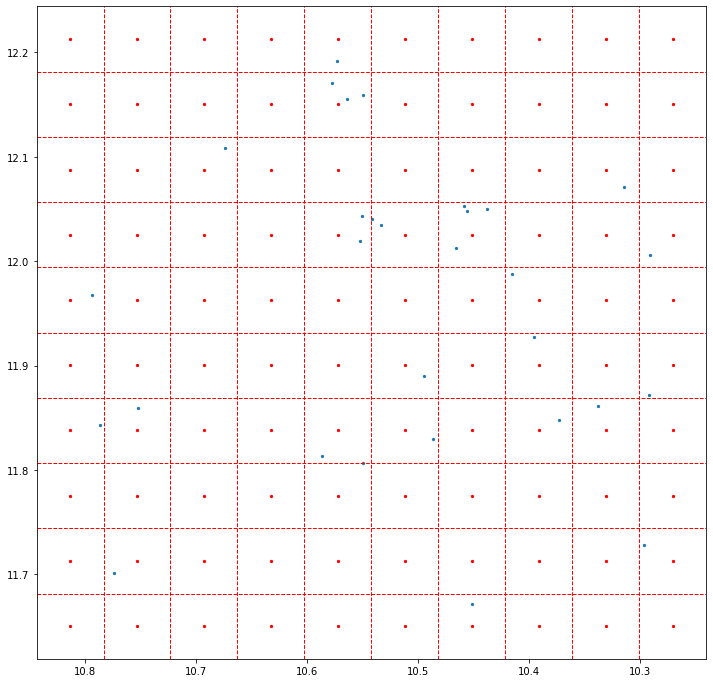

In [11]:
fig = plt.figure(figsize=(12,12))
plt.scatter(x,y,s=5)
plt.axis([xmax,xmin,ymin,ymax])
xgrid_centre=[]
ygrid_centre=[]

for i in range(10):
    plt.axhline(ymin+i*deltay, color='r', linestyle='--', linewidth = 1)
    plt.axvline(xmin+i*deltax, color='r', linestyle='--', linewidth = 1)
    ygrid_centre.append(ymax-(i+1)*deltay+0.5*deltay)
    xgrid_centre.append(xmax-(i+1)*deltax+0.5*deltax)

for i in range(len(xgrid_centre)):
    for j in range(len(ygrid_centre)):
        plt.scatter(xgrid_centre[i],ygrid_centre[j],s=5,c='r')

In [12]:
kernel = np.zeros((10,10))

In [13]:
belong_grid_x=[]
belong_grid_y=[]
for i in range(len(x)):
    distance=np.zeros((10,10))
    for j in range(len(ygrid_centre)):
        for k in range(len(xgrid_centre)):
            distance[j][k]=((x[i]-xgrid_centre[k])**2+(y[i]-ygrid_centre[j])**2)
    c=np.argmin(distance)
    belong_grid_y.append(c//10)
    belong_grid_x.append(c%10)
    kernel[belong_grid_y[i]][9-belong_grid_x[i]]=kernel[belong_grid_y[i]][9-belong_grid_x[i]]+1


In [14]:
for i in range(10):
    for j in range(10):
        kernel[i][j]=kernel[i][j]/coeff

In [15]:
y_g=[]
x_g=[]
value_g=[]

for i in range(len(kernel)):
    for j in range(len(kernel[i])):
        if kernel[i][j]!=0:
            x_g.append(xgrid_centre[j])
            y_g.append(ygrid_centre[i])
            value_g.append(kernel[i][j])
            

In [16]:
def optimal_sigma(sigma1):
    probability=[]
    pro=1
    for i in range(len(x_g)):
        pro_sum=0
        for j in range(len(x_g)):
            if i!=j:
                #pro_sum=pro_sum+((1/(sigma1*math.sqrt(2*math.pi)))*gauss(x[i]*60,y[i]*60,x[j]*60,y[j]*60,sigma1))
                pro_sum=pro_sum+((1/((sigma1**2)*2*math.pi))*gauss(x[i]*60,y[i]*60,x[j]*60,y[j]*60,sigma1))
                
        probability.append(pro_sum)
        
    for i in range(len(probability)):
        pro=pro*probability[i]
    return pro
                
                

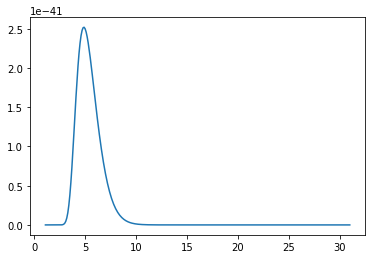

In [17]:
sigma_x=[]
origin=1
for i in range(300):
    sigma_x.append((i+1)*0.1+origin)

likelihood=[]
for i in range(len(sigma_x)):
    likelihood.append(optimal_sigma(sigma_x[i]))



plt.plot(sigma_x,likelihood)

In [18]:
a=likelihood.index(max(likelihood))
print(sigma_x[a])

4.9


In [19]:
kernel1 = np.zeros((10,10))
kernel2= np.zeros((10,10))

for i in range(len(x_g)):
    sum=0
    for j in range(len(kernel1)):
        for k in range(10):
            kernel1[j][k]=gauss(xgrid_centre[k]*60,ygrid_centre[j]*60,x_g[i]*60,y_g[i]*60,4.9)#sigma
            sum=sum+kernel1[j][k]
    for j in range(len(kernel1)):
        for k in range(10):
            #kernel1[j][k]=value_g[i]*kernel1[j][k]/sum
            kernel1[j][k]=value_g[i]*kernel1[j][k]*(1/(2*math.pi*4.9*4.9))#sigma
            #kernel1[j][k]=value_g[i]*kernel1[j][k]*(1/(math.sqrt(2*math.pi)*4.9))#sigma
            kernel2[j][k]=kernel2[j][k]+kernel1[j][k]
'''
for i in range(len(kernel2)):
    for j in range(10):
         kernel2[j][k]=(kernel2[j][k])
'''

'\nfor i in range(len(kernel2)):\n    for j in range(10):\n         kernel2[j][k]=(kernel2[j][k])\n'

"\nfor i in range(10):\n    plt.axhline(ymin+i*deltay, color='r', linestyle='--', linewidth = 1)\n    plt.axvline(xmin+i*deltax, color='r', linestyle='--', linewidth = 1)\n"

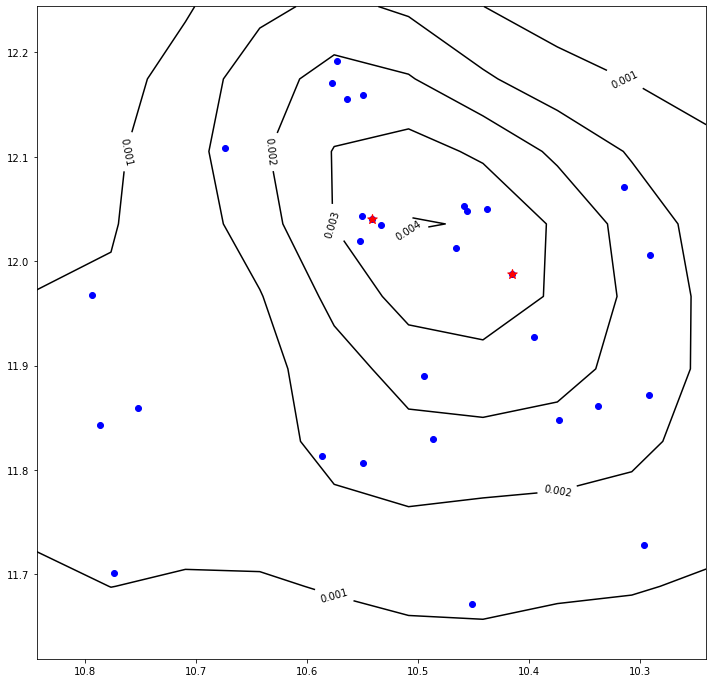

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
cset = ax.contour(xx, yy, np.rot90(kernel2,-1), 5,colors='black')
#cset = ax.contour(xx, yy, kernel, colors='black')
ax.clabel(cset, inline=1, fontsize=10)
#ax.imshow(kernel2,extent=[xmin, xmax, ymin, ymax])
#ax.imshow(np.rot90(kernel),extent=[xmin, xmax, ymin, ymax])
ax.scatter(x,y,c='b')
plt.axis([xmax,xmin,ymin,ymax])
ax.scatter(ra_final,dec_final, c='r', s=100, marker='*')
'''
for i in range(10):
    plt.axhline(ymin+i*deltay, color='r', linestyle='--', linewidth = 1)
    plt.axvline(xmin+i*deltax, color='r', linestyle='--', linewidth = 1)
'''